a_r: 3.0
b_r: 1.5


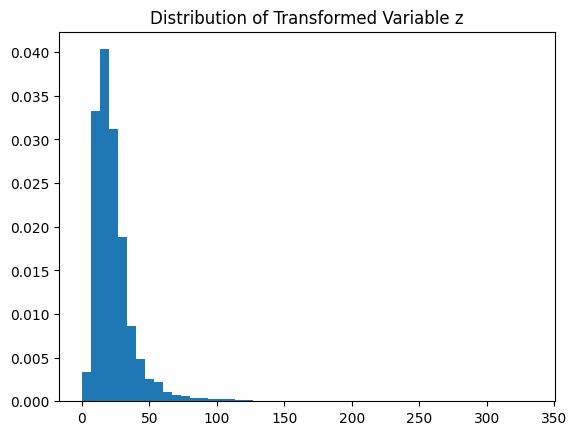

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
df = pd.read_csv("/content/data.csv",
                 encoding='latin1',
                 low_memory=False)
x = df['no2'].dropna().values
r = 102303599

a_r = 0.5 * (r % 7)
b_r = 0.3 * ((r % 5) + 1)
print("a_r:", a_r)
print("b_r:", b_r)
z = x + a_r * np.sin(b_r * x)
plt.hist(z, bins=50, density=True)
plt.title("Distribution of Transformed Variable z")
plt.show()

Epoch 0 | D Loss: 0.9362 | G Loss: 0.5330
Epoch 500 | D Loss: 1.3542 | G Loss: 0.6905
Epoch 1000 | D Loss: 1.2437 | G Loss: 0.7044
Epoch 1500 | D Loss: 1.4667 | G Loss: 0.6140
Epoch 2000 | D Loss: 1.4034 | G Loss: 0.7035
Epoch 2500 | D Loss: 1.3948 | G Loss: 0.6799


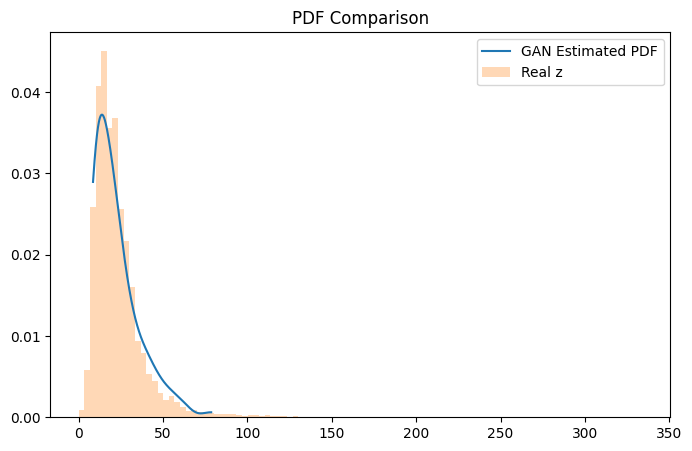

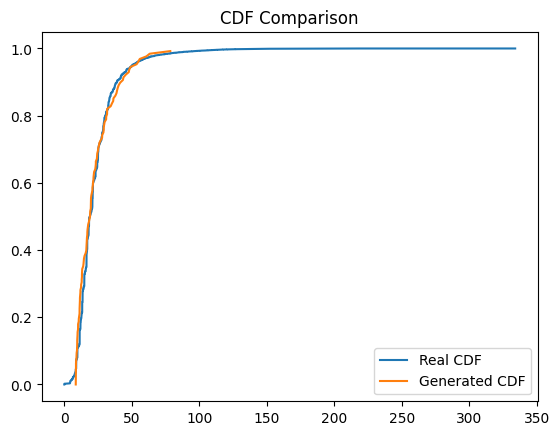

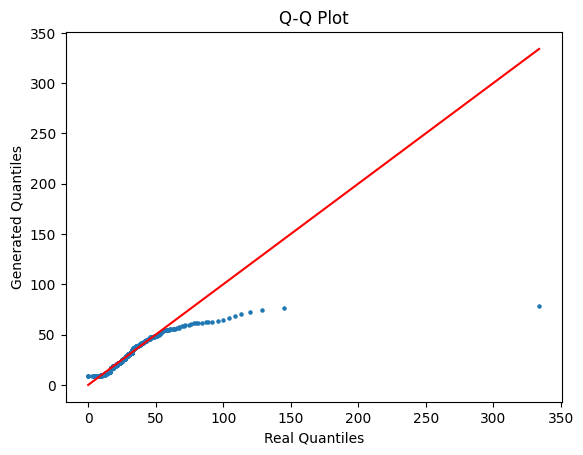

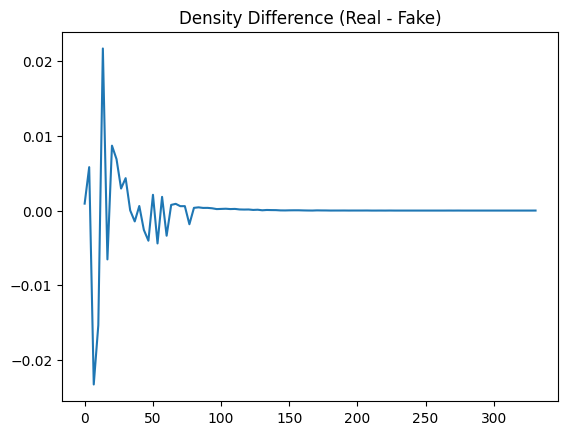

In [6]:
import torch
import torch.nn as nn
class Generator(nn.Module):
  def __init__(self):
      super().__init__()
      self.model = nn.Sequential(
          nn.Linear(1, 64),
          nn.LeakyReLU(0.2),
          nn.Linear(64, 64),
          nn.LeakyReLU(0.2),
          nn.Linear(64, 1)
      )

  def forward(self, x):
      return self.model(x)
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(1, 64),
            nn.LeakyReLU(0.2),
            nn.Linear(64, 64),
            nn.LeakyReLU(0.2),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)
G = Generator()
D = Discriminator()

criterion = nn.BCELoss()

optimizer_G = torch.optim.Adam(G.parameters(), lr=0.0005)
optimizer_D = torch.optim.Adam(D.parameters(), lr=0.0005)

epochs = 3000
batch_size = 128
z_tensor = torch.tensor(z).float()

for epoch in range(epochs):

    # Sample real batch
    idx = np.random.randint(0, len(z), batch_size)
    real_data = z_tensor[idx].unsqueeze(1)

    real_labels = torch.ones(batch_size, 1)
    fake_labels = torch.zeros(batch_size, 1)

    # Generate fake batch
    noise = torch.randn(batch_size, 1)
    fake_data = G(noise)

    # ---------------------
    # Train Discriminator
    # ---------------------
    loss_real = criterion(D(real_data), real_labels)
    loss_fake = criterion(D(fake_data.detach()), fake_labels)

    loss_D = loss_real + loss_fake

    optimizer_D.zero_grad()
    loss_D.backward()
    optimizer_D.step()

    # ---------------------
    # Train Generator
    # ---------------------
    output = D(fake_data)
    loss_G = criterion(output, real_labels)

    optimizer_G.zero_grad()
    loss_G.backward()
    optimizer_G.step()

    if epoch % 500 == 0:
        print(f"Epoch {epoch} | D Loss: {loss_D.item():.4f} | G Loss: {loss_G.item():.4f}")
        noise = torch.randn(10000, 1)
generated = G(noise).detach().numpy().flatten()
from scipy.stats import gaussian_kde

kde = gaussian_kde(generated)

x_vals = np.linspace(min(generated), max(generated), 1000)

plt.figure(figsize=(8,5))
plt.plot(x_vals, kde(x_vals), label="GAN Estimated PDF")
plt.hist(z, bins=100, density=True, alpha=0.3, label="Real z")
plt.legend()
plt.title("PDF Comparison")
plt.show()
from scipy.stats import gaussian_kde
import numpy as np
import matplotlib.pyplot as plt

real_sorted = np.sort(z)
fake_sorted = np.sort(generated)

real_cdf = np.arange(len(real_sorted)) / len(real_sorted)
fake_cdf = np.arange(len(fake_sorted)) / len(fake_sorted)

plt.plot(real_sorted, real_cdf, label="Real CDF")
plt.plot(fake_sorted, fake_cdf, label="Generated CDF")
plt.legend()
plt.title("CDF Comparison")
plt.show()
quantiles = np.linspace(0, 1, 1000)

real_q = np.quantile(z, quantiles)
fake_q = np.quantile(generated, quantiles)

plt.scatter(real_q, fake_q, s=5)
plt.plot(real_q, real_q, color='red')
plt.title("Q-Q Plot")
plt.xlabel("Real Quantiles")
plt.ylabel("Generated Quantiles")
plt.show()
hist_real, bins = np.histogram(z, bins=100, density=True)
hist_fake, _ = np.histogram(generated, bins=bins, density=True)

plt.plot(bins[:-1], hist_real - hist_fake)
plt.title("Density Difference (Real - Fake)")
plt.show()